In [15]:
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


In [16]:
data = join('datasets', 'eps_policy_data.csv')

df = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True).dropna()

df.head(10)

,eps,rr_rate,pb
date,,,
2005-09-01,5.051,7.25,1.428370
2005-12-01,5.053,7.50,1.432683
2006-03-01,5.053,7.50,1.932705
2006-06-01,5.729,7.50,1.564217
2006-09-01,6.281,7.50,1.879248
2006-12-01,6.281,7.50,2.061234
2007-03-01,6.178,7.50,2.354255
2007-06-01,7.440,7.50,2.829528
2007-09-01,7.695,6.00,2.584650


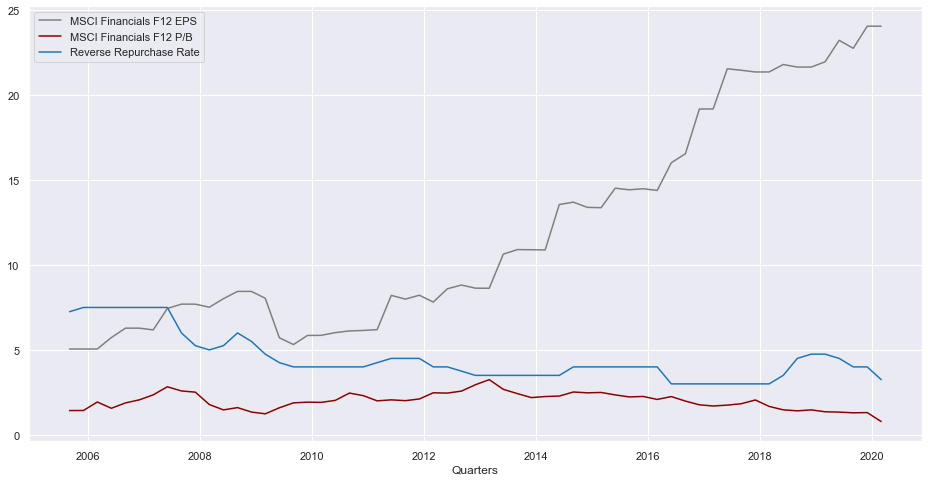

In [17]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(16,8))

plt.plot(df.eps, color='tab:gray', label='MSCI Financials F12 EPS')
plt.plot(df.pb, color='darkred', label='MSCI Financials F12 P/B')
plt.plot(df.rr_rate, color='tab:blue', label='Reverse Repurchase Rate')
#plt.title('')
plt.legend()
plt.xlabel('Quarters')

plt.show()

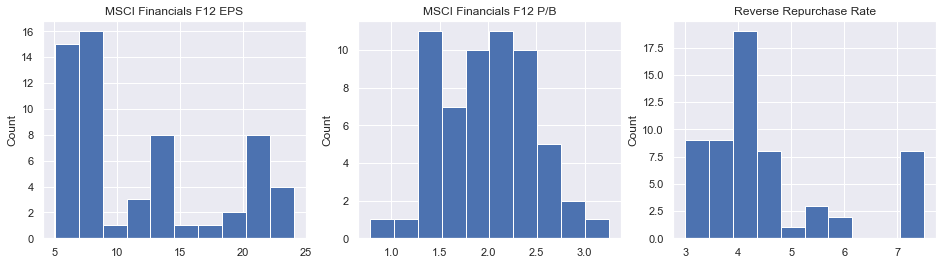

In [18]:
def normal_plots():
    fig = plt.figure(figsize=(16,4))

    plt.subplot(1,3,1)
    plt.hist(df.eps)
    plt.title('MSCI Financials F12 EPS')
    plt.ylabel('Count')

    plt.subplot(1,3,2)
    plt.hist(df.pb)
    plt.title('MSCI Financials F12 P/B')
    plt.ylabel('Count')
    
    plt.subplot(1,3,3)
    plt.hist(df.rr_rate)
    plt.title('Reverse Repurchase Rate')
    plt.ylabel('Count')
    
    plt.show()

normal_plots()

In [19]:
#testing for stationarity
def adf_test(series, name=None, num=None):
    result = adfuller(series)
    if name == None:
        name = str(series.name)
    if num != None:
        name = 'Series %s' % str(num)
    print('\n%s:' %name)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    
eps = df.eps
p_book = df.pb
policy = df.rr_rate

adf_test(eps)
print('Sample size: %s' %len(eps))
adf_test(p_book)
print('Sample size: %s' %len(p_book))
adf_test(policy)
print('Sample size: %s' %len(policy))


eps:
ADF Statistic: 0.746259
p-value: 0.990717
Sample size: 59

pb:
ADF Statistic: -1.459014
p-value: 0.553680
Sample size: 59

rr_rate:
ADF Statistic: -2.336725
p-value: 0.160397
Sample size: 59


In [20]:
# The following code consolidates transofrmation steps into one (and backtracks transformations)
def normalize(series):
    ave, stdev = series.mean(), series.std()
    series = (series-ave)/stdev
    return series

def annual_vol(series):
    stdevs = series.groupby(series.index.year).std()
    return series.index.map(lambda d: stdevs.loc[d.year])

def variance_correct(series):
    return series/annual_vol(series)

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

def make_stationary(*data, plot=False, headers=True):
    stdata = []
    for d in data:
        if headers == True:
            header = d.name
        d = normalize(d)
        d = d.diff().fillna(method="bfill")
        d = variance_correct(d)
        #d = seasonality_correct(d).fillna(method="bfill")
        d.name = header
        stdata.append(d)
        
    if len(stdata) == 1:
        return stdata[0]
    else:
        return stdata

In [32]:
series = make_stationary(eps, p_book, policy)

nseries = pd.concat(series, axis=1).fillna(method='ffill').replace([np.inf, -np.inf], np.nan).dropna()
nseries

,eps,pb,rr_rate
date,,,
2007-03-01,-0.165043,0.888586,0.000000
2007-06-01,2.022175,1.441260,0.000000
2007-09-01,0.408601,-0.742590,-2.088932
2007-12-01,0.000000,-0.220617,-1.044466
2008-03-01,-0.549401,-2.063171,-0.450988
2008-06-01,1.521419,-0.894108,0.450988
2008-09-01,1.288980,0.381528,1.352963
2008-12-01,0.000000,-0.744109,-0.901975
2009-03-01,-0.337810,-0.484679,-2.323790



eps:
ADF Statistic: -4.220763
p-value: 0.000608
Sample size: 56

pb:
ADF Statistic: -6.578856
p-value: 0.000000
Sample size: 56

rr_rate:
ADF Statistic: -4.268771
p-value: 0.000503
Sample size: 56


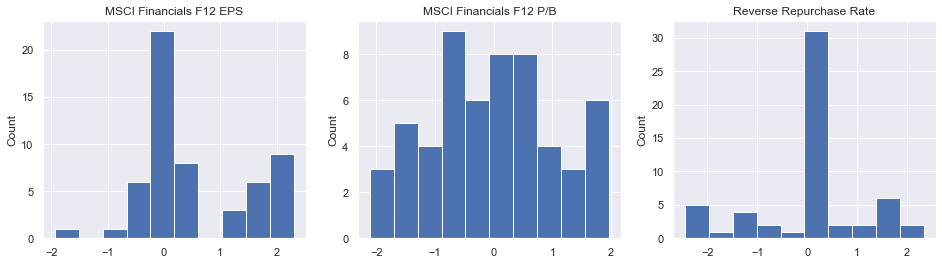

In [22]:
#series = make_stationary(eps, p_book, policy)
series = [eps, p_book, policy]
nseries = []

for s in series:
    header = s.name
    s = normalize(s)
    s = s.diff().fillna(method="bfill")
    s = variance_correct(s).fillna(method="bfill")
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    s.name = header
    nseries.append(s)
    adf_test(s)
    print('Sample size: %s' %len(s))

fig = plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.hist(nseries[0])
plt.title('MSCI Financials F12 EPS')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(nseries[1])
plt.title('MSCI Financials F12 P/B')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.hist(nseries[2])
plt.title('Reverse Repurchase Rate')
plt.ylabel('Count')

plt.show()

In [23]:
def granger(s1, s2, lag=4):
    granger_df = pd.concat([s1, s2], axis=1).dropna()
    grangercausalitytests(granger_df, lag)

print('Testing causality\n')
granger(nseries[0],nseries[2])
print('\n-----------------------------------------------\n')
granger(nseries[2],nseries[0])
print('\n-----------------------------------------------\n')
granger(nseries[1],nseries[2])
print('\n-----------------------------------------------\n')
granger(nseries[2],nseries[1])


Testing causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0905  , p=0.1542  , df_denom=52, df_num=1
ssr based chi2 test:   chi2=2.2112  , p=0.1370  , df=1
likelihood ratio test: chi2=2.1679  , p=0.1409  , df=1
parameter F test:         F=2.0905  , p=0.1542  , df_denom=52, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4663  , p=0.2407  , df_denom=49, df_num=2
ssr based chi2 test:   chi2=3.2318  , p=0.1987  , df=2
likelihood ratio test: chi2=3.1388  , p=0.2082  , df=2
parameter F test:         F=1.4663  , p=0.2407  , df_denom=49, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1927  , p=0.3230  , df_denom=46, df_num=3
ssr based chi2 test:   chi2=4.1227  , p=0.2485  , df=3
likelihood ratio test: chi2=3.9702  , p=0.2647  , df=3
parameter F test:         F=1.1927  , p=0.3230  , df_denom=46, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7583 

**Conclusion: Low F-statistic for every lag means that reverse repurchase rate and MSCI EPS don't cause each other.**

### Fitting VAR Model

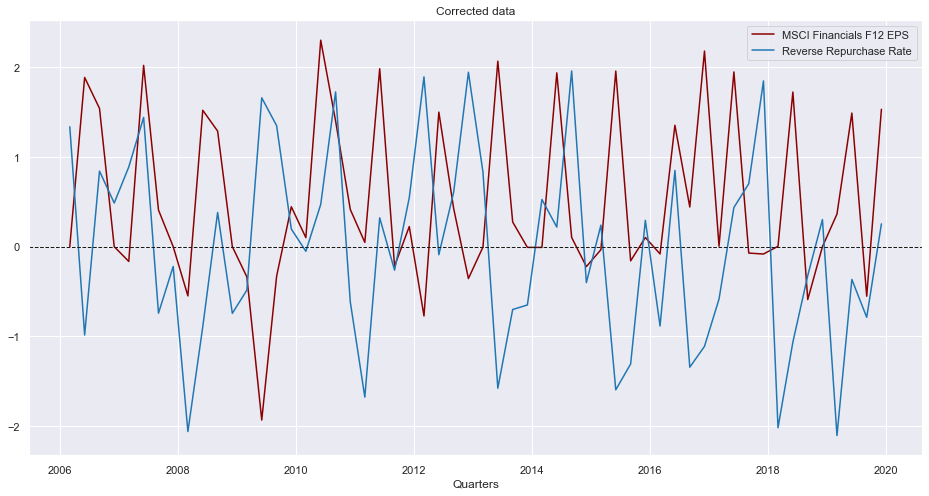

In [24]:
# Plotting partial autocorrelation

fig = plt.figure(figsize=(16,8))

plt.plot(nseries[0], color='darkred', label='MSCI Financials F12 EPS')
plt.plot(nseries[1], color='tab:blue', label='Reverse Repurchase Rate')
plt.title('Corrected data')
plt.legend()
plt.xlabel('Quarters')
plt.axhline(linewidth=1, linestyle='dashed', color='k')
plt.show()

In [25]:
# Checking for cross-correlation

for lag in range(1,14):
    s_eps = series[0].iloc[lag:]
    s_pol = series[1].iloc[:-lag]
    print('Lag %s' %lag)
    print(pearsonr(s_eps, s_pol))
    print('--------')

Lag 1
(-0.3073218215689889, 0.0189433148680619)
--------
Lag 2
(-0.23798629581787187, 0.07464161120325825)
--------
Lag 3
(-0.17263857403569244, 0.2032492179292996)
--------
Lag 4
(-0.09869795585082035, 0.4734330246345232)
--------
Lag 5
(-0.01481691425729172, 0.9153128223952789)
--------
Lag 6
(0.042286715593016125, 0.763684731348931)
--------
Lag 7
(0.0963475825300486, 0.4968423812928683)
--------
Lag 8
(0.14760551223575719, 0.30129661421474757)
--------
Lag 9
(0.19128062639910268, 0.18329661301777025)
--------
Lag 10
(0.20210400895232677, 0.16373315970388425)
--------
Lag 11
(0.2402202992833225, 0.10005119847684384)
--------
Lag 12
(0.28552588183323174, 0.05171861303562166)
--------
Lag 13
(0.3468494631445622, 0.018199312447710152)
--------


In [26]:
### AUTOMATE MODEL SELECTION
def fit_tsmodel(data, model='VAR', lags=4):
    models = ['VAR','SARIMAX']

    if model in models:
        if model == models[0]:
            model = VAR
        elif model == models[1]:
            model == SARIMAX
    else:
        print('Model not supported')
        return None
    
    fmodel = model(data)          
    res = fmodel.fit(maxlags=lags)
    return res

In [27]:
def create_df(*series):
    df = pd.concat(series, axis=1).dropna()
    n = []
    for i in series:
        n.append(i.name)
    df.columns = n
    return df

st_policy = nseries[2]
st_eps = nseries[0]
st_pb = nseries[1]

fdf = create_df(st_policy, st_eps)
res = fit_tsmodel(fdf,lags=12)
res.summary()

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Jan, 2021
Time:                     09:40:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.67610
Nobs:                     44.0000    HQIC:                   1.40050
Log likelihood:          -89.1361    FPE:                    2.59925
AIC:                     0.648614    Det(Omega_mle):         1.05695
--------------------------------------------------------------------
Results for equation rr_rate
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               1.158403         0.753093            1.538           0.124
L1.rr_rate          0.371048         0.223448            1.661           0.097
L1.eps             -0.011684         0.275834           -0.042    

In [28]:
print('R2 score: ' + r2_score(res.fittedvalues['eps']+res.resid['eps'],
  res.fittedvalues['eps']))

TypeError: can only concatenate str (not "numpy.float64") to str

In [ ]:
irf = res.irf(10)
irf.plot(orth=False, impulse='rr_rate')